# Code required to generate Figure 1. 
Note that the code in 01_Prepare Data should be run before this. This figure will differ slightly from the one presented in the paper as it is run using the sample data (due to file size constraints) uploaded to the online repository. The full raw data is available on request from the authors.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Rectangle
from matplotlib.transforms import ScaledTranslation
import seaborn as sns
from palettable.mycarta import Cube1_6
from palettable.scientific.sequential import Bamako_6_r

from paiskintonetools import setup_matplotlib
from paiskintonetools.stats import p_formatter

import statsmodels.formula.api as smf

setup_matplotlib(dpi=200)

In [2]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

Load reference absorption spectra.

In [3]:
wavelengths = np.linspace(700, 1100, 100)
df_hbo2 = pd.read_csv("longwl_spectra/HbO2.csv", index_col=0)
hbo2 = (
    np.interp(wavelengths, df_hbo2["0"], df_hbo2["1"], left=np.nan, right=np.nan)
    * 2.303
    * 150
    / 64500
)
df_hb = pd.read_csv("longwl_spectra/Hb.csv", index_col=0)
hb = (
    np.interp(wavelengths, df_hb["0"], df_hb["1"], left=np.nan, right=np.nan)
    * 2.303
    * 150
    / 64500
)
df_lipid = pd.read_csv("longwl_spectra/lipid.csv", index_col=0)
lipid = (
    np.interp(
        wavelengths, df_lipid["nm"], df_lipid["mu_a(/m)"], left=np.nan, right=np.nan
    )
    / 100
)  # /cm
df_water = pd.read_csv("longwl_spectra/water_full.csv", index_col=0)
water = np.interp(
    wavelengths,
    df_water["Wavelength (nm)"],
    df_water["Absorption (/cm)"],
    left=np.nan,
    right=np.nan,
)
df_collagen = pd.read_csv("longwl_spectra/collagen.csv", index_col=0)
collagen = np.interp(
    wavelengths,
    df_collagen["Wavelength (nm)"],
    df_collagen["Absorption (/cm)"],
    left=np.nan,
    right=np.nan,
)
melanin = 519 * (wavelengths / 500) ** (-3.5) * 0.4  # /cm

Load ITA experimental data

In [4]:
df_pa_all = pd.read_parquet("../01_Prepare Data/pa_values_extracted_all_meta.parquet")

In [5]:
wavelengths_pa = np.array(
    [
        700.0,
        730.0,
        760.0,
        800.0,
        850.0,
        910.0,
        930.0,
        950.0,
        980.0,
        1030.0,
        1080.0,
        1100.0,
        1210.0,
    ]
)

In [6]:
df_pa = df_pa_all.query("Location=='neck'").reset_index(drop=True)
df_pa = df_pa.query("OtherDetail==''").reset_index(drop=True)
df_pa = df_pa.query("`ROI Name`=='skin'").reset_index(drop=True)
pd.unique(df_pa["ROI Name"])
df_pa.columns

Index(['SkinID', 'Region', 'Pigment', 'Side', 'ITA', 'CIE-L*', 'CIE-a*',
       'CIE-b*', 'Melanin', 'Eryth.', 'sR', 'sG', 'sB', 'File', 'ScanNumber',
       'Location', 'RunNumber', 'RunLetter', 'VitiligoPigment', 'Parallel',
       'OtherDetail', 'VitiligoLeftRight', 'ROI Name', 'ROI Number',
       'spectrum_mean', 'spectrum_median', 'spectrum_std',
       'spectrum_positive_mean', 'spectrum_positive_median',
       'spectrum_positive_std', 'thb_mean', 'thb_median', 'thb_std',
       'thb_positive_mean', 'thb_positive_median', 'thb_positive_std',
       'so2_mean', 'so2_median', 'so2_std', 'corrected_spectrum_mean',
       'corrected_spectrum_median', 'corrected_spectrum_std',
       'corrected_spectrum_positive_mean',
       'corrected_spectrum_positive_median', 'corrected_spectrum_positive_std',
       'corrected_thb_mean', 'corrected_thb_median', 'corrected_thb_std',
       'corrected_thb_positive_mean', 'corrected_thb_positive_median',
       'corrected_thb_positive_std', 'corre

In [7]:
from pandas.api.types import is_numeric_dtype

(df_pa["BMI"].dtype)

dtype('float64')

In [8]:
agg_functions = dict()
grp_by = ["SkinID", "RunNumber"]
for c in df_pa.columns:
    if c in grp_by:
        continue
    if "spectrum" in c:
        agg_functions[c] = lambda x: np.nanmean(np.vstack(x), axis=0)
    elif is_numeric_dtype(df_pa[c].dtype):
        agg_functions[c] = lambda x: np.nanmean(x)
    else:
        agg_functions[c] = "first"

df_pa_mean_reps = df_pa.groupby(grp_by).agg(agg_functions)
df_pa_mean = df_pa_mean_reps.groupby(level=0).agg(agg_functions).reset_index()
df_pa_mean.head()

,SkinID,Region,Pigment,Side,ITA,CIE-L*,CIE-a*,CIE-b*,Melanin,Eryth.,...,corrected_thb_positive_mean,corrected_thb_positive_median,corrected_thb_positive_std,corrected_so2_mean,corrected_so2_median,corrected_so2_std,Age,Gender,Fitzpatrick Type,BMI
0,SKIN01,Carotid Artery,,,54.196,64.894,6.008,10.720,29.234,15.492,...,0.000018,0.000012,0.000020,0.348037,0.290644,0.238499,27.0,Male,2,25.5
1,SKIN02,Carotid Artery,,,38.540,60.364,6.482,12.998,34.216,17.772,...,0.000017,0.000010,0.000019,0.316020,0.234624,0.281227,31.0,Male,2,29.9
2,SKIN03,Carotid Artery,,,17.108,55.956,8.254,19.356,36.648,20.672,...,0.000025,0.000014,0.000028,0.284872,0.202178,0.276493,43.0,Male,3,27.5
3,SKIN04,Carotid Artery,,,30.570,61.218,5.026,18.996,34.300,12.750,...,0.000019,0.000012,0.000018,0.262532,0.183986,0.264104,25.0,Female,3,22.0
4,SKIN05,Carotid Artery,,,36.326,62.684,3.940,17.234,34.092,11.334,...,0.000016,0.000010,0.000015,0.282149,0.196746,0.278885,27.0,Female,3,21.5


In [9]:
df_ita = df_pa_mean

Make the melanometry figure.

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


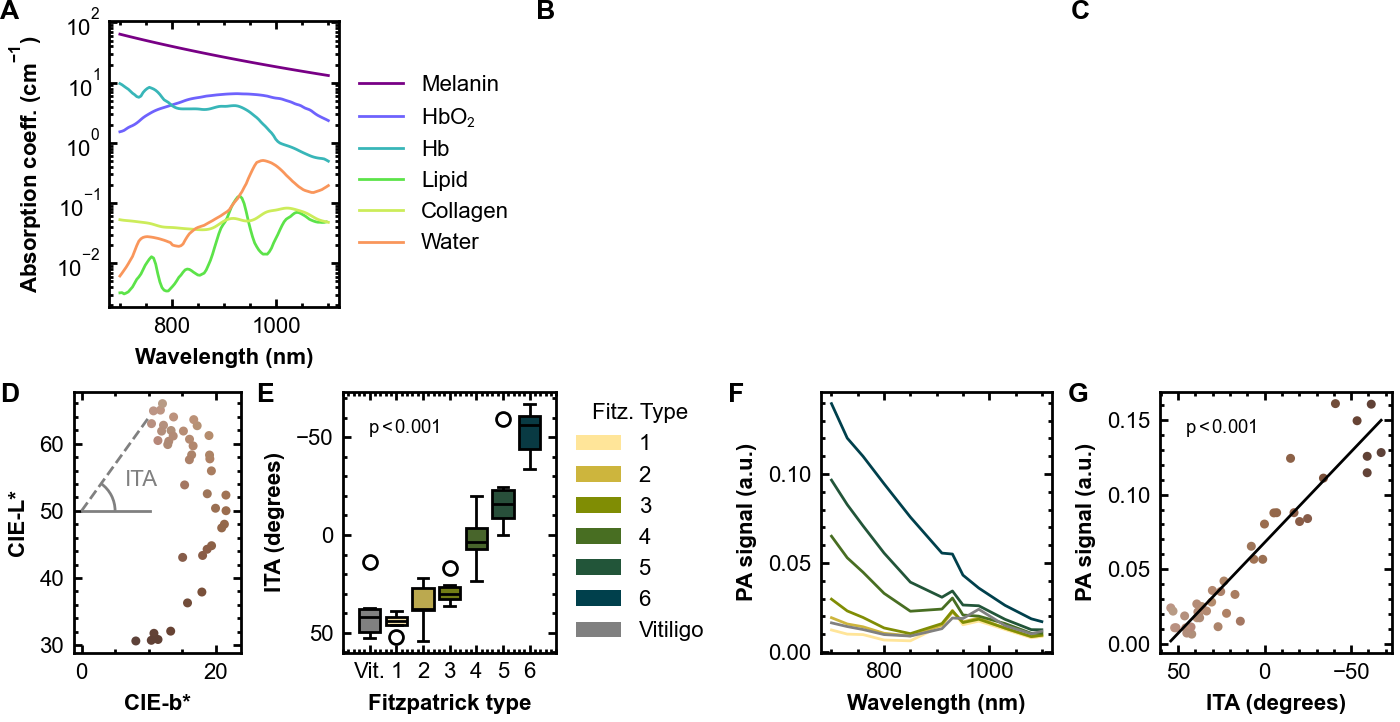

In [10]:
fig = plt.figure(figsize=(7, 1.9 * 2 * 0.95), layout="constrained")

shift_transform = ScaledTranslation(-1 / 4, 0, fig.dpi_scale_trans)


def custom_transform(x, y=0):
    return ScaledTranslation(-x / 4, -y / 4, fig.dpi_scale_trans)


subfiga, subfigb = fig.subfigures(2, 1, height_ratios=[1, 0.9])

subfigsb = subfigb.subfigures(1, 4, width_ratios=[0.75, 1.4, 1, 1])
ax2, ax1, ax_lower_1, ax_lower_2 = [s.subplots() for s in subfigsb]

# Calculate the mean RGB colours over FP type.
fp_colours = Bamako_6_r.mpl_colors
fp_colours = dict([(str(a), fp_colours[a - 1]) for a in range(1, 7)])
fp_colours["Vitiligo"] = "gray"

fp_means = df_ita.groupby("Fitzpatrick Type")[["sR", "sG", "sB"]].median()

subfigsa = subfiga.subfigures(1, 3, width_ratios=[2, 2, 1.25])
ax_absorption_spectra, ax11, ax12 = [s.subplots() for s in subfigsa]
ax11.axis("off")
ax12.axis("off")
# Plot the absorption spectra.
ax_absorption_spectra.semilogy(
    wavelengths, melanin, label="Melanin", c=Cube1_6.mpl_colors[0]
)
ax_absorption_spectra.semilogy(
    wavelengths, hbo2, label="HbO$_2$", c=Cube1_6.mpl_colors[1]
)
ax_absorption_spectra.semilogy(wavelengths, hb, label="Hb", c=Cube1_6.mpl_colors[2])
ax_absorption_spectra.semilogy(
    wavelengths, lipid, label="Lipid", c=Cube1_6.mpl_colors[3]
)
ax_absorption_spectra.semilogy(
    wavelengths, collagen, label="Collagen", c=Cube1_6.mpl_colors[4]
)
ax_absorption_spectra.semilogy(
    wavelengths, water, label="Water", c=Cube1_6.mpl_colors[5]
)
ax_absorption_spectra.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax_absorption_spectra.set_xlabel("Wavelength (nm)")
ax_absorption_spectra.set_ylabel(r"Absorption coeff. ($\mathdefault{cm^{-1}}$)")

# Boxplot.
df_ita_fit = df_ita.copy()
m = df_ita_fit["Fitzpatrick Type"] == "Vitiligo"
df_ita_fit.loc[m, "Fitzpatrick Type"] = "Vit."
order = ["Vit.", "1", "2", "3", "4", "5", "6"]
colour_order = ["Vitiligo", "1", "2", "3", "4", "5", "6"]

bp = sns.boxplot(
    data=df_ita_fit,
    y="ITA",
    x="Fitzpatrick Type",
    ax=ax1,
    hue="Fitzpatrick Type",
    linecolor="black",
    legend=False,
    palette=[fp_colours[x] for x in colour_order],
    order=order,
    hue_order=order,
)
ax1.set_xlim(-1, 7)

df_ita_fit.loc[m, "Fitzpatrick Type"] = 0
df_ita_fit["Fitzpatrick Type"] = df_ita_fit["Fitzpatrick Type"].astype(int)

s = smf.ols(
    "ITA ~ Q('Fitzpatrick Type')", data=df_ita_fit[["ITA", "Fitzpatrick Type"]]
).fit()

p_values = s.pvalues
weights = s.params
ax1.text(
    0.0,
    1.0,
    p_formatter(p_values["Q('Fitzpatrick Type')"]),
    transform=ax1.transAxes + custom_transform(-0.5, 0.5),
    va="top",
    ha="left",
    fontsize="small",
)
# rf"$\mathdefault{{ITA}} \sim \mathdefault{{{weights["Intercept"]:.0f} - {-weights["Q('Fitzpatrick Type')"]:.0f} \times FP}}$"
ax1.text(
    0.0,
    1.0,
    "",
    transform=ax1.transAxes + custom_transform(-0.5, 1),
    va="top",
    ha="left",
    fontsize="small",
)

ax1.invert_yaxis()
subfigsa[-1].suptitle("")
ax1.set_title("")
ax1.set_ylabel("ITA (degrees)")
ax1.set_xlabel("Fitzpatrick type")

# Plot the L-B plane and show ITA.
ax2.scatter(
    df_ita["CIE-b*"], df_ita["CIE-L*"], c=df_ita[["sR", "sG", "sB"]].values / 255, s=5
)
ax2.set_aspect("equal", adjustable="datalim")
n_example = 0
x, y = df_ita.loc[n_example, "CIE-b*"], df_ita.loc[n_example, "CIE-L*"]
x, y = x * 0.95, (y - 50) * 0.95 + 50
ax2.plot([0, x], [50, y], linestyle="--", linewidth=1, c="gray")
ax2.plot([0, x], [50, 50], linewidth=1, c="gray")
theta = np.arctan2(y - 50, x)
angle_arc = Arc((0, 50), 10, 10, theta1=0, theta2=np.rad2deg(theta), edgecolor="gray")
ax2.text(
    10 * np.cos(theta / 2),
    10 * np.sin(theta / 2) + 50,
    "ITA",
    color="gray",
    va="center",
    ha="center",
)
ax2.add_patch(angle_arc)
## ADD LABELS
ax2.set_xlabel("CIE-b*")
ax2.set_ylabel("CIE-L*")
ax2.set_xlim([0, None])

# Make a Fitzpatrick type legend.
handles = []
labels = []
for i, row in fp_means.iterrows():
    r = Rectangle(
        (0, 0), 1 / 4, 1 / 4, facecolor=fp_colours[i], transform=fig.dpi_scale_trans
    )
    handles.append(r)
    labels.append(i)
ax1.legend(
    handles, labels, loc="center left", bbox_to_anchor=(1, 0.5), title="Fitz. Type"
)

subfigsa[0].text(0, 1, "A", va="top", ha="left", fontsize="large", fontweight="bold")
subfigsa[1].text(0, 1, "B", va="top", ha="left", fontsize="large", fontweight="bold")
subfigsa[2].text(0, 1, "C", va="top", ha="left", fontsize="large", fontweight="bold")

for fp, g in df_pa_mean.groupby("Fitzpatrick Type"):
    ax_lower_1.plot(
        wavelengths_pa[:-1],
        np.mean(np.vstack(g["spectrum_positive_mean"]), axis=0)[:-1],
        c=fp_colours[fp],
    )

ax_lower_1.set_xlabel("Wavelength (nm)")
ax_lower_1.set_ylabel("PA signal (a.u.)")
subfigsb[0].text(0, 1, "D", va="top", ha="left", fontsize="large", fontweight="bold")
subfigsb[1].text(0, 1, "E", va="top", ha="left", fontsize="large", fontweight="bold")
subfigsb[2].text(0, 1, "F", va="top", ha="left", fontsize="large", fontweight="bold")
subfigsb[3].text(0, 1, "G", va="top", ha="left", fontsize="large", fontweight="bold")

y = df_pa_mean["spectrum_positive_mean"].apply(lambda x: x[0])
ax_lower_2.scatter(
    df_pa_mean["ITA"], y, s=5, c=df_pa_mean[["sR", "sG", "sB"]].values / 255
)
df_pa_mean["y"] = y
s = smf.ols("y ~ ITA", data=df_pa_mean).fit()
p_values = s.pvalues
weights = s.params

a, b = np.min(df_pa_mean["ITA"]), np.max(df_pa_mean["ITA"])
ita_eval = np.linspace(a, b, 1000)
ax_lower_2.plot(
    ita_eval, s.get_prediction(pd.DataFrame({"ITA": ita_eval})).predicted, c="k"
)
ax_lower_2.text(
    0.0,
    1.0,
    p_formatter(p_values["ITA"]),
    transform=ax_lower_2.transAxes + custom_transform(-0.5, 0.5),
    va="top",
    ha="left",
    fontsize="small",
)

ax_lower_2.set_xlabel("ITA (degrees)")
ax_lower_2.set_ylabel("PA signal (a.u.)")
ax_lower_2.invert_xaxis()


fig.savefig("figures/figure1.pdf", dpi=300)
fig.savefig("figures/figure1.svg", dpi=300)
plt.show()